# COMS4060A - Introduction of Data Visualisation & Exploration: Assignment 2 

## Group Members
* Lisa Godiwn - 2437980
* Nihal Ranchod - 2427378
* Zach Schwark - 2434346

## Coding Practices

- Dataframe `df` is the original data.
- `df_copy` is a copy of the original dataframe `df` and is used only at the start of the data cleaning process in Question 1.
- `df` used from Question 3 onwards is a new dataframe created by using a cleaned .csv file that is created at the end of Question 2. 

In [160]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from geopy.distance import geodesic
from datetime import datetime

Reading in the .csv and creating a dataframe.

In [161]:
df = pd.read_csv("./nyc_taxis/nyc_taxis.csv")

df_copy = df.copy()
display(df_copy.head())

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982,40.768,-73.965,40.766,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980,40.739,-73.999,40.731,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979,40.764,-74.005,40.710,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010,40.720,-74.012,40.707,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973,40.793,-73.973,40.783,N,435


### Question 1: Data Cleaning

1. There are several outliers in the data. Identify these and give justification for why you can remove them from the analysis. (Hint: look at trip duration, speed, distance, etc).
    1. Initial Exploration: Check for missing values, basic statistics, and unusual data points.
    2. Outlier Detection Using Boxplots:
        - **Trip Duration:** Create a boxplot to visualize the distribution of trip durations. Identify outliers as trips with durations significantly shorter or longer than the typical range, based on the Interquartile Range (IQR) method.
        - **Distance Calculation:** Calculate the trip distance using the Haversine formula, which measures the great-circle distance between the pickup and dropoff locations. Use a boxplot to detect outliers in the trip distance data.
        - **Speed Calculation:** Compute the average speed for each trip using the calculated distance and trip duration. Create a boxplot to identify trips with implausibly high or low speeds, indicating potential data entry errors or anomalies.
    3. Remove Outliers: For each of the three variables (trip duration, distance, and speed), remove data points identified as outliers using the IQR method. Outliers are defined as values outside the range of `(Q1 - 1.5 x IQR)` and `(Q3 + 1.5 x IQR)` are the first and third quartiles, respectively.

Initial Exploration: Check for missing values, basic statistics, and unusual data points.

In [162]:
display(df_copy.info())
pd.set_option('display.float_format', '{:.3f}'.format)
display(df_copy.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   id                  1458644 non-null  object 
 1   vendor_id           1458644 non-null  int64  
 2   pickup_datetime     1458644 non-null  object 
 3   dropoff_datetime    1458644 non-null  object 
 4   passenger_count     1458644 non-null  int64  
 5   pickup_longitude    1458644 non-null  float64
 6   pickup_latitude     1458644 non-null  float64
 7   dropoff_longitude   1458644 non-null  float64
 8   dropoff_latitude    1458644 non-null  float64
 9   store_and_fwd_flag  1458644 non-null  object 
 10  trip_duration       1458644 non-null  int64  
dtypes: float64(4), int64(3), object(4)
memory usage: 122.4+ MB


None

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,1458644.000,1458644.000,1458644.000,1458644.000,1458644.000,1458644.000,1458644.000
mean,1.535,1.665,-73.973,40.751,-73.973,40.752,959.492
std,0.499,1.314,0.071,0.033,0.071,0.036,5237.432
min,1.000,0.000,-121.933,34.360,-121.933,32.181,1.000
25%,1.000,1.000,-73.992,40.737,-73.991,40.736,397.000
50%,2.000,1.000,-73.982,40.754,-73.980,40.755,662.000
75%,2.000,2.000,-73.967,40.768,-73.963,40.770,1075.000
max,2.000,9.000,-61.336,51.881,-61.336,43.921,3526282.000


In [163]:
missing_values = df_copy.isnull().sum()
print(f'Missing values in each column: \n{missing_values}')

Missing values in each column: 
id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64


Trip Duration Outlier Detection

In [164]:
# Convert the trip duration to minutes
df_copy['trip_duration_min'] = df_copy['trip_duration'] / 60
display(df_copy[['trip_duration', 'trip_duration_min']].head())

,trip_duration,trip_duration_min
0,455,7.583
1,663,11.050
2,2124,35.400
3,429,7.150
4,435,7.250


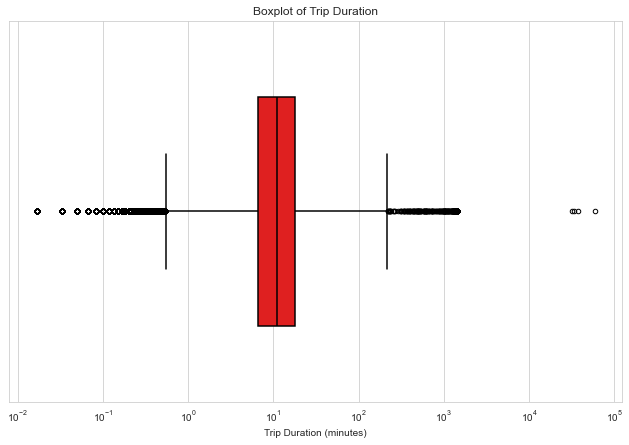

<Figure size 432x288 with 0 Axes>

In [165]:
# Plot the trip duration to visually inspect outliers
plt.figure(figsize=(11, 7))
sns.set_style('whitegrid')
sns.boxplot(
    x=df_copy["trip_duration_min"],
    color='red',
    gap=0.25,
    whis=2.5,
    linecolor='black',
    linewidth=1.5,
    fliersize=4.5,
    log_scale=True
)

plt.xlabel('Trip Duration (minutes)')
plt.title('Boxplot of Trip Duration')
plt.savefig('./Plots/Plots[1]/trip_duration_boxplot.png')
plt.show()
plt.clf()

In [166]:
# Define thresholds based on boxplot (IQR method)
Q1_duration = df_copy['trip_duration_min'].quantile(0.25)
Q3_duration = df_copy['trip_duration_min'].quantile(0.75)
IQR_duration = Q3_duration - Q1_duration

# Outliers are typically defined as points beyond 1.5 times the IQR
lower_bound_duration = Q1_duration - 1.5 * IQR_duration
upper_bound_duration = Q3_duration + 1.5 * IQR_duration

print(f'Q1_duration: {Q1_duration}')
print(f'Q3_duration: {Q3_duration}')
print(f'IQR_duration: {IQR_duration}')
print(f'Lower bound: {lower_bound_duration}')
print(f'Upper bound: {upper_bound_duration}')

# Number of entries before cleaning
original_count = len(df_copy)

# Remove outliers for trip duration
df_cleaned = df_copy[(df_copy['trip_duration_min'] > lower_bound_duration) & (df_copy['trip_duration_min'] < upper_bound_duration)]

# Number of entries after cleaning
cleaned_count = len(df_cleaned)

# Number of entries removed
removed_count = original_count - cleaned_count

print(f'Original number of entries: {original_count}')
print(f'Number of entries after cleaning: {cleaned_count}')
print(f'Number of entries removed: {removed_count}')

Q1_duration: 6.616666666666666
Q3_duration: 17.916666666666668
IQR_duration: 11.3
Lower bound: -10.333333333333336
Upper bound: 34.866666666666674
Original number of entries: 1458644
Number of entries after cleaning: 1384424
Number of entries removed: 74220


Trip Distance Outlier Detection

In [167]:
# Calculate the distance between pickup and dropoff locations using Haversine formula
def haversine_np(lon1, lat1, lon2, lat2):
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2
    c = 2 * np.arcsin(np.sqrt(a))
    km = 6367 * c
    return km

df_cleaned['trip_distance_km'] = haversine_np(df_cleaned['pickup_longitude'], df_cleaned['pickup_latitude'], df_cleaned['dropoff_longitude'], df_cleaned['dropoff_latitude'])

display(df_cleaned[['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'trip_distance_km']].head())

C:\Users\nihal\AppData\Local\Temp\ipykernel_12476\342926809.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['trip_distance_km'] = haversine_np(df_cleaned['pickup_longitude'], df_cleaned['pickup_latitude'], df_cleaned['dropoff_longitude'], df_cleaned['dropoff_latitude'])


,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_distance_km
0,-73.982,40.768,-73.965,40.766,1.498
1,-73.980,40.739,-73.999,40.731,1.804
3,-74.010,40.720,-74.012,40.707,1.485
4,-73.973,40.793,-73.973,40.783,1.188
5,-73.983,40.742,-73.992,40.749,1.098


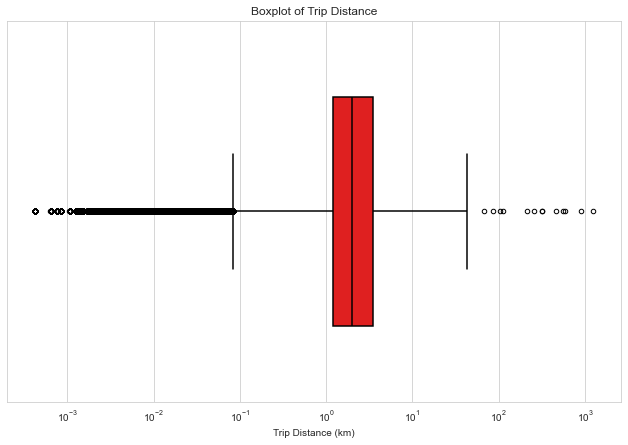

<Figure size 432x288 with 0 Axes>

In [168]:
# Plot the trip distance to visually inspect outliers
plt.figure(figsize=(11, 7))
sns.boxplot(
    x=df_cleaned["trip_distance_km"],
    color='red',
    gap=0.25,
    whis=2.5,
    linecolor='black',
    linewidth=1.5,
    fliersize=4.5,
    log_scale=True
)

plt.xlabel('Trip Distance (km)')
plt.title('Boxplot of Trip Distance')
plt.savefig('./Plots/Plots[1]/trip_distance_boxplot.png')
plt.show()
plt.clf()

In [169]:
# Define thresholds based on boxplot (IQR method)
Q1_distance = df_cleaned['trip_distance_km'].quantile(0.25)
Q3_distance = df_cleaned['trip_distance_km'].quantile(0.75)
IQR_distance = Q3_distance - Q1_distance

lower_bound_distance = Q1_distance - 1.5 * IQR_distance
upper_bound_distance = Q3_distance + 1.5 * IQR_distance

print(f'Q1_distance: {Q1_distance}')
print(f'Q3_distance: {Q3_distance}')
print(f'IQR_distance: {IQR_distance}')
print(f'Lower bound: {lower_bound_distance}')
print(f'Upper bound: {upper_bound_distance}')

# Number of entries before cleaning
original_count = len(df_cleaned)

# Remove outliers for trip distance
df_cleaned = df_cleaned[(df_cleaned['trip_distance_km'] > lower_bound_distance) & (df_cleaned['trip_distance_km'] < upper_bound_distance)]

# Number of entries after cleaning
cleaned_count = len(df_cleaned)

# Number of entries removed
removed_count = original_count - cleaned_count

print(f'Original number of entries: {original_count}')
print(f'Number of entries after cleaning: {cleaned_count}')
print(f'Number of entries removed: {removed_count}')

Q1_distance: 1.1974858282621814
Q3_distance: 3.483906343696884
IQR_distance: 2.2864205154347026
Lower bound: -2.2321449448898725
Upper bound: 6.9135371168489375
Original number of entries: 1384424
Number of entries after cleaning: 1276732
Number of entries removed: 107692


Trip Speed Outlier Detection

In [170]:
df_cleaned['speed_kmh'] = df_cleaned['trip_distance_km'] / (df_cleaned['trip_duration'] / 3600)
display(df_cleaned[['trip_distance_km', 'trip_duration', 'speed_kmh']].head())

,trip_distance_km,trip_duration,speed_kmh
0,1.498,455,11.849
1,1.804,663,9.798
3,1.485,429,12.458
4,1.188,435,9.830
5,1.098,443,8.925


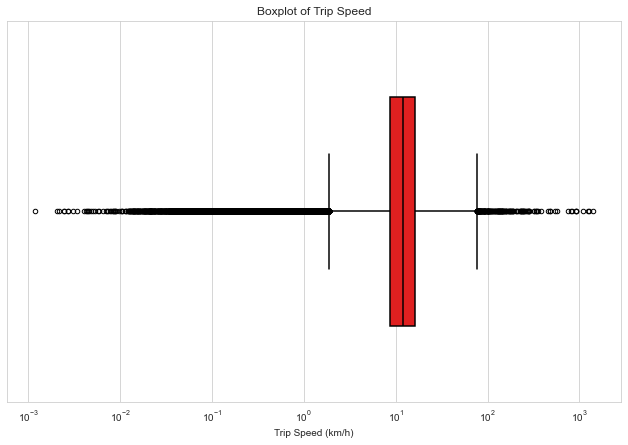

<Figure size 432x288 with 0 Axes>

In [171]:
# Plot the trip speed to visually inspect outliers
plt.figure(figsize=(11, 7))
sns.boxplot(
    x=df_cleaned["speed_kmh"],
    color='red',
    gap=0.25,
    whis=2.5,
    linecolor='black',
    linewidth=1.5,
    fliersize=4.5,
    log_scale=True
)

plt.xlabel('Trip Speed (km/h)')
plt.title('Boxplot of Trip Speed')
plt.savefig('./Plots/Plots[1]/trip_speed_boxplot.png')
plt.show()
plt.clf()

In [172]:
# Define thresholds based on boxplot (IQR method)
Q1_speed = df_cleaned['speed_kmh'].quantile(0.25)
Q3_speed = df_cleaned['speed_kmh'].quantile(0.75)
IQR_speed = Q3_speed - Q1_speed

lower_bound_speed = Q1_speed - 1.5 * IQR_speed
upper_bound_speed = Q3_speed + 1.5 * IQR_speed

print(f'Q1_speed: {Q1_speed}')
print(f'Q3_speed: {Q3_speed}')
print(f'IQR_speed: {IQR_speed}')
print(f'Lower bound: {lower_bound_speed}')
print(f'Upper bound: {upper_bound_speed}')

# Number of entries before cleaning
original_count = len(df_cleaned)

# Remove outliers for trip speed
df_cleaned = df_cleaned[(df_cleaned['speed_kmh'] > lower_bound_speed) & (df_cleaned['speed_kmh'] < upper_bound_speed)]

# Number of entries after cleaning
cleaned_count = len(df_cleaned)

# Number of entries removed
removed_count = original_count - cleaned_count

print(f'Original number of entries: {original_count}')
print(f'Number of entries after cleaning: {cleaned_count}')
print(f'Number of entries removed: {removed_count}')

Q1_speed: 8.783111873053258
Q3_speed: 16.27753997881952
IQR_speed: 7.494428105766261
Lower bound: -2.458530285596133
Upper bound: 27.51918213746891
Original number of entries: 1276732
Number of entries after cleaning: 1236820
Number of entries removed: 39912


In [173]:
# Final cleaned dataset
print("Shape of cleaned dataset: ", df_cleaned.shape)
display(df_cleaned.head())

Shape of cleaned dataset:  (1236820, 14)


,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,trip_duration_min,trip_distance_km,speed_kmh
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982,40.768,-73.965,40.766,N,455,7.583,1.498,11.849
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980,40.739,-73.999,40.731,N,663,11.050,1.804,9.798
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010,40.720,-74.012,40.707,N,429,7.150,1.485,12.458
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973,40.793,-73.973,40.783,N,435,7.250,1.188,9.830
5,id0801584,2,2016-01-30 22:01:40,2016-01-30 22:09:03,6,-73.983,40.742,-73.992,40.749,N,443,7.383,1.098,8.925


**Outlier Identification and Justification for Removal**

**1. Trip Duration Outliers**

- **Analysis**: 
  - The first and third quartiles (Q1 and Q3) of trip duration are approximately 6.62 minutes and 17.92 minutes, respectively, resulting in an Interquartile Range (IQR) of 11.3 minutes.
  - Outliers were identified as trips with durations below the lower bound of -10.33 minutes or above the upper bound of 34.87 minutes. Since negative durations are not possible, only the upper bound was considered.
  - **Results**: After applying this threshold, 74,220 entries were removed, reducing the dataset from 1,458,644 to 1,384,424 entries.

- **Justification for Removal**:
  - **Extreme durations**: Trips with durations significantly longer than the upper bound may result from data entry errors, traffic anomalies, or scenarios where the taxi meter was left running unintentionally. These extreme cases do not represent typical taxi trips and could distort the analysis of average trip times and patterns.

**2. Trip Distance Outliers**

- **Analysis**:
  - The IQR for trip distance was calculated as 2.29 km, with Q1 at 1.20 km and Q3 at 3.48 km. The lower bound was -2.23 km (which is not physically possible) and the upper bound was 6.91 km.
  - **Results**: Applying this threshold removed 107,692 entries, reducing the dataset further to 1,276,732 entries.

- **Justification for Removal**:
  - **Improbable distances**: Trips with distances far exceeding the upper bound may indicate unusually long journeys, possibly due to outliers in pickup/dropoff coordinates or GPS errors. These outliers could mislead any spatial analysis or skew results concerning the typical distance traveled in NYC.

**3. Speed Outliers**

- **Analysis**:
  - For speed, the IQR was 7.49 km/h, with Q1 at 8.78 km/h and Q3 at 16.28 km/h, leading to a lower bound of -2.46 km/h (impossible for real trips) and an upper bound of 27.52 km/h.
  - **Results**: This step removed 39,912 entries, leaving a final dataset of 1,236,820 entries.

- **Justification for Removal**:
  - **Unrealistic speeds**: Extremely high speeds may occur due to incorrect time or distance calculations, possibly indicating data errors or misrecorded trips. Similarly, very low speeds could result from trips that involved significant waiting time, or errors where the vehicle might not have moved but the trip was recorded. Removing these ensures that the analysis focuses on realistic driving conditions, leading to more accurate insights into traffic patterns and trip efficiency.

**Summary**

Outliers across trip duration, distance, and speed were systematically identified using boxplots and the IQR method. Removing these outliers is essential to maintain data integrity, representativeness, and statistical robustness in the analysis. The process ensures that the dataset accurately reflects typical taxi trips in NYC, enabling more reliable and meaningful conclusions from subsequent analyses.

### Question 2: Feature Engineering

Generate additional columns for at least these features (but you’re welcome to add more!):
- Distance of trip
- Day of week
- Average speed of trip

Note: Distance of trip and average speed of trip were already calculated in the Data Cleaning steps in Question 1.

In [174]:
display(df_cleaned[['trip_distance_km', 'speed_kmh']])

,trip_distance_km,speed_kmh
0,1.498,11.849
1,1.804,9.798
3,1.485,12.458
4,1.188,9.830
5,1.098,8.925
...,...,...
1458637,3.535,16.746
1458638,2.316,20.139
1458639,1.224,5.665
1458642,1.092,10.538


In [175]:
# Extract day of the week

# Convert pickup and dropoff datetime columns to datetime objects
df_cleaned['pickup_datetime'] = pd.to_datetime(df_cleaned['pickup_datetime'])
df_cleaned['dropoff_datetime'] = pd.to_datetime(df_cleaned['dropoff_datetime'])

# Extract day of the week (0=Monday, 6=Sunday)
df_cleaned['day_of_week'] = df_cleaned['pickup_datetime'].dt.dayofweek

# Map integer values to day names
day_of_week_map = {
    0: 'Monday',
    1: 'Tuesday',
    2: 'Wednesday',
    3: 'Thursday',
    4: 'Friday',
    5: 'Saturday',
    6: 'Sunday'
}
df_cleaned['day_of_week_str'] = df_cleaned['day_of_week'].map(day_of_week_map)

# Additional feature: Extract hour of the day
df_cleaned['pickup_hour'] = df_cleaned['pickup_datetime'].dt.hour

# Additional feature: Time of day (morning, afternoon, evening)
def time_of_day(hour):
    if 5 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 17:
        return 'Afternoon'
    elif 17 <= hour < 21:
        return 'Evening'
    else:
        return 'Night'

df_cleaned['time_of_day'] = df_cleaned['pickup_hour'].apply(time_of_day)

# All new features
display(df_cleaned[['trip_distance_km', 'speed_kmh', 'day_of_week', 'day_of_week_str', 'pickup_hour', 'time_of_day']].head())

# Save the cleaned and feature-enhanced DataFrame for further analysis
df_cleaned.to_csv('./nyc_taxis/nyc_taxi_cleaned_with_features.csv', index=False)

,trip_distance_km,speed_kmh,day_of_week,day_of_week_str,pickup_hour,time_of_day
0,1.498,11.849,0,Monday,17,Evening
1,1.804,9.798,6,Sunday,0,Night
3,1.485,12.458,2,Wednesday,19,Evening
4,1.188,9.830,5,Saturday,13,Afternoon
5,1.098,8.925,5,Saturday,22,Night


### Question 3: Time-based

[3.1] Which day of the week is the most popular? Show plots to motivate your answer.

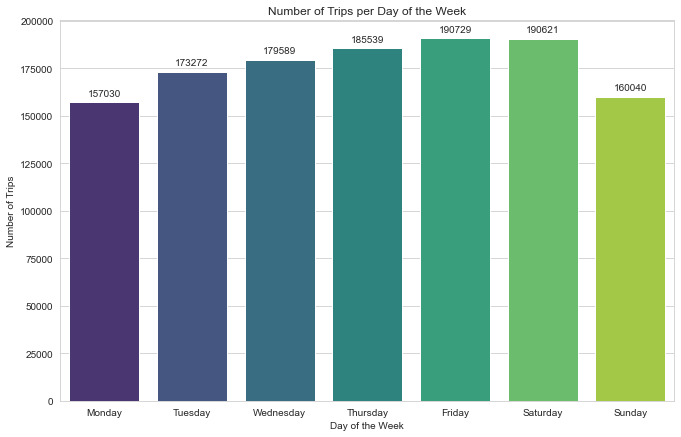

<Figure size 432x288 with 0 Axes>

In [176]:
# Read the cleaned dataset
df = pd.read_csv('./nyc_taxis/nyc_taxi_cleaned_with_features.csv')

day_of_week_counts = df['day_of_week'].value_counts().sort_index()
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

plt.figure(figsize=(11, 7))
ax = sns.barplot(x=days, y=day_of_week_counts, hue=days, dodge=False, estimator="sum", palette='viridis')

# Add the total above each bar
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height:.0f}', 
                (p.get_x() + p.get_width() / 2., height), 
                ha='center', va='center', 
                xytext=(0, 9), 
                textcoords='offset points')

plt.xlabel('Day of the Week')
plt.ylabel('Number of Trips')
plt.title('Number of Trips per Day of the Week')
plt.savefig('./Plots/Plots[3]/Plots[3.1]/num_of_trips_per_day_of_the_week.png')
plt.show()
plt.clf()

Friday is the most popular day of the week.

[3.2] What hour of the day is the most popular on each day? Plot a distribution of the hours and make observations and give possible suggestions for why the data looks like it does.

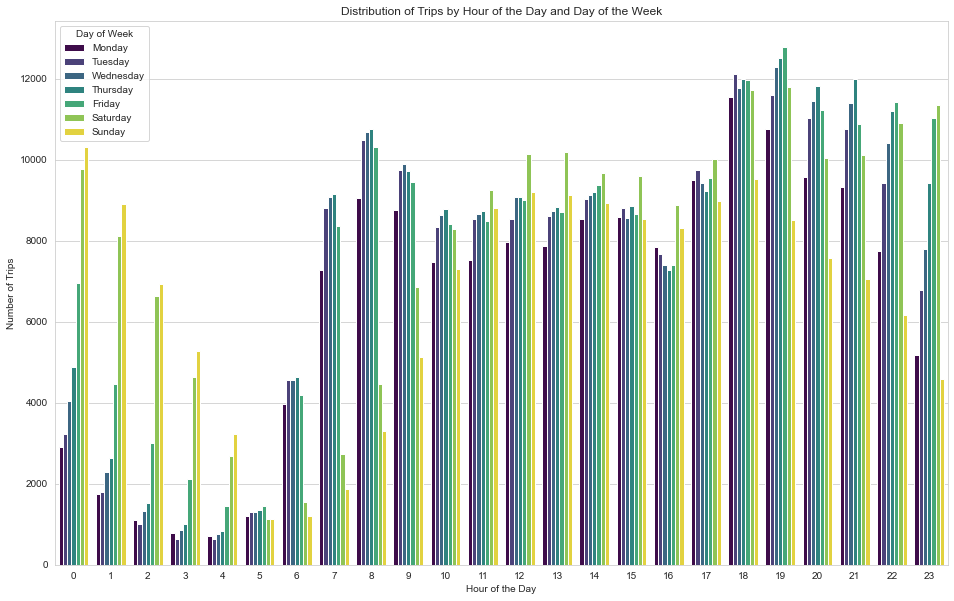

<Figure size 432x288 with 0 Axes>

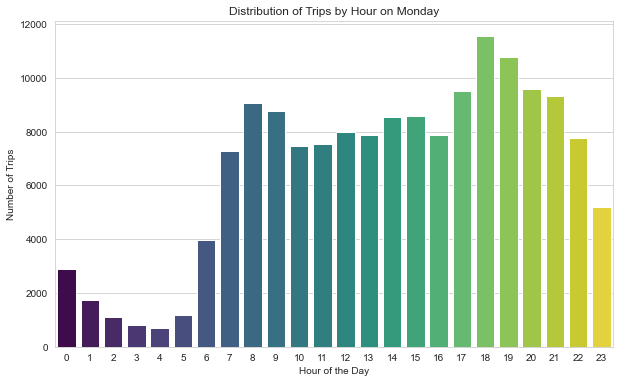

<Figure size 432x288 with 0 Axes>

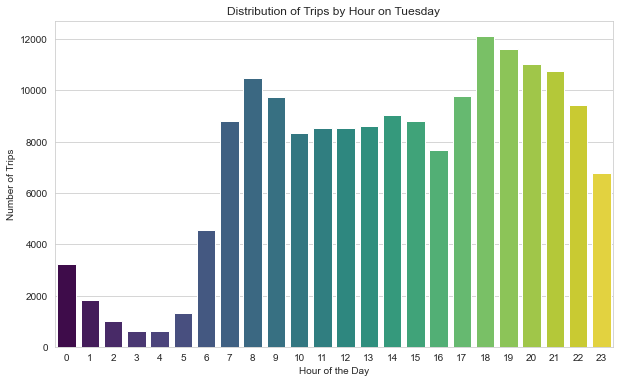

<Figure size 432x288 with 0 Axes>

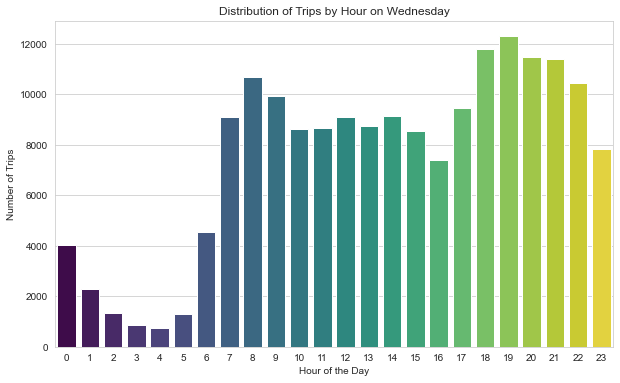

<Figure size 432x288 with 0 Axes>

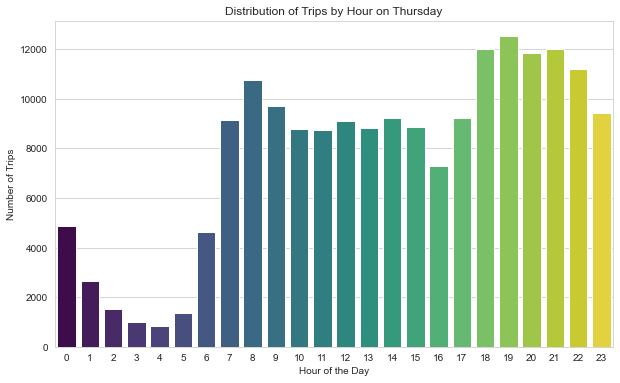

<Figure size 432x288 with 0 Axes>

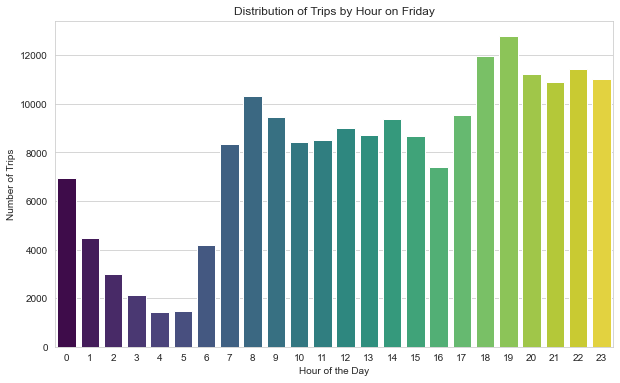

<Figure size 432x288 with 0 Axes>

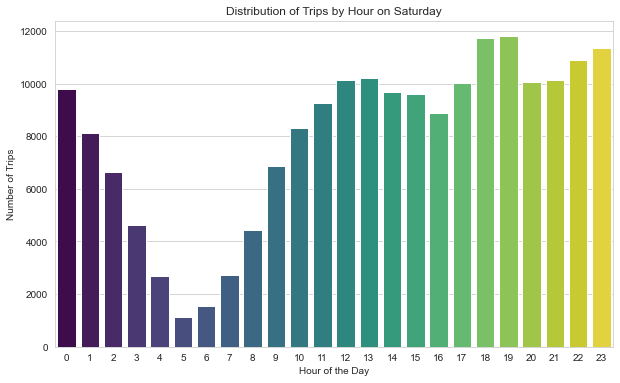

<Figure size 432x288 with 0 Axes>

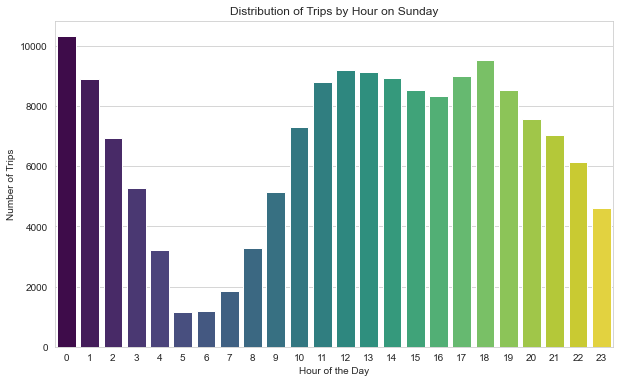

<Figure size 432x288 with 0 Axes>

In [177]:
import os

# Define the folder to save the plots
output_folder = './Plots/Plots[3]/Plots[3.2]'
os.makedirs(output_folder, exist_ok=True)

# Define the days of the week
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Overall distribution of trips by hour and day of the week
plt.figure(figsize=(16, 10))
sns.countplot(data=df, x='pickup_hour', hue='day_of_week', palette='viridis')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Trips')
plt.title('Distribution of Trips by Hour of the Day and Day of the Week')
plt.legend(title='Day of Week', labels=days)
plt.savefig(os.path.join(output_folder, 'trips_by_hour_of_the_day_and_day_of_the_week.png'))
plt.show()
plt.clf()

# Individual plots for each day of the week
for i, day in enumerate(days):
    plt.figure(figsize=(10, 6))
    sns.countplot(data=df[df['day_of_week'] == i], x='pickup_hour', hue='pickup_hour', palette='viridis', legend=False)
    plt.xlabel('Hour of the Day')
    plt.ylabel('Number of Trips')
    plt.title(f'Distribution of Trips by Hour on {day}')
    plt.savefig(os.path.join(output_folder, f'trips_by_hour_on_{day.lower()}.png'))
    plt.show()
    plt.clf()


[3.3] Investigate the differences between weekdays and weekends. What would account for this? 

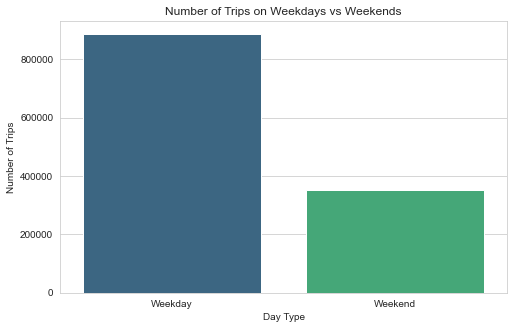

<Figure size 432x288 with 0 Axes>

In [178]:
# Create a new column indicating whether the day is a weekend
df['is_weekend'] = df['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)

# Compare trips on weekdays vs weekends
weekend_vs_weekday_counts = df['is_weekend'].value_counts()
plt.figure(figsize=(8, 5))
sns.barplot(x=['Weekday', 'Weekend'], y=weekend_vs_weekday_counts, hue=['Weekday', 'Weekend'], dodge=False, estimator="sum", palette='viridis')
plt.xlabel('Day Type')
plt.ylabel('Number of Trips')
plt.title('Number of Trips on Weekdays vs Weekends')
plt.savefig('./Plots/Plots[3]/Plots[3.3]/num_trips_on_weekdays_vs_weekends.png')
plt.show()
plt.clf()

[3.4] Look at how these patterns change on the major holidays (do they change?). Look at the following: St. Patrick’s Day, Easter, Memorial Day, Valentine’s Day, Martin Luther King Day. Make sure you use the correct dates for these for the relevant year.

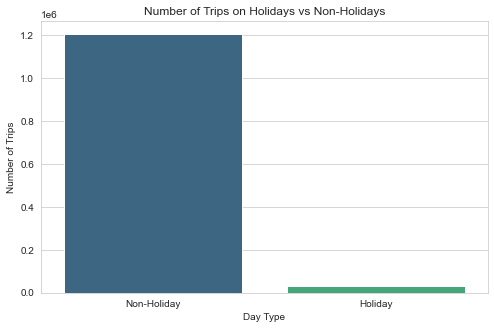

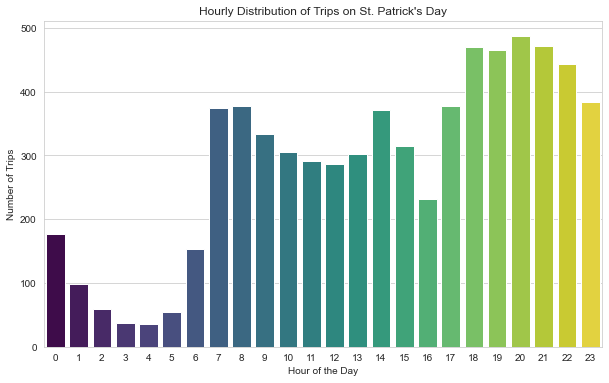

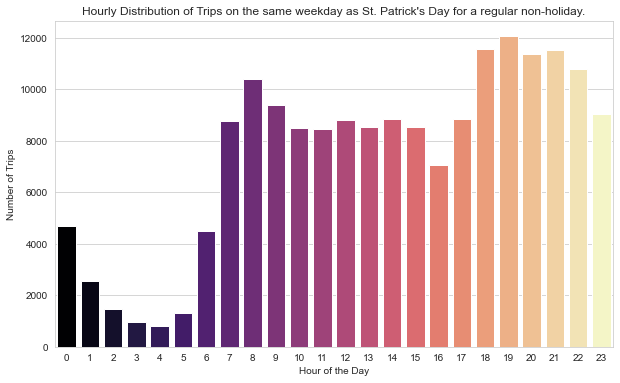

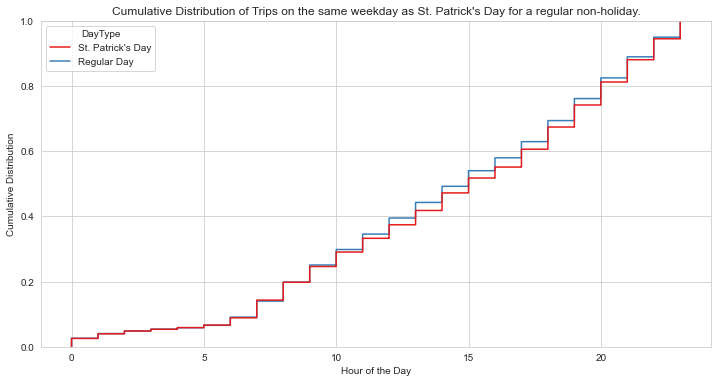

<Figure size 432x288 with 0 Axes>

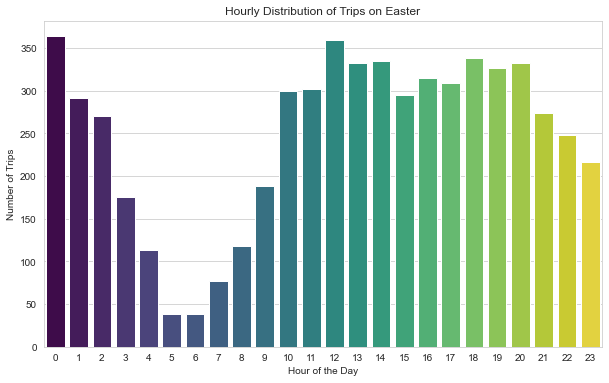

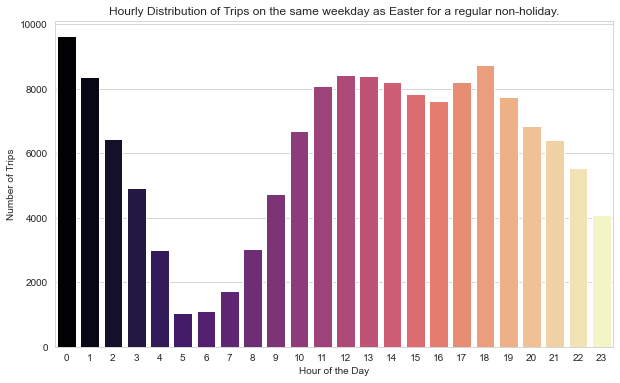

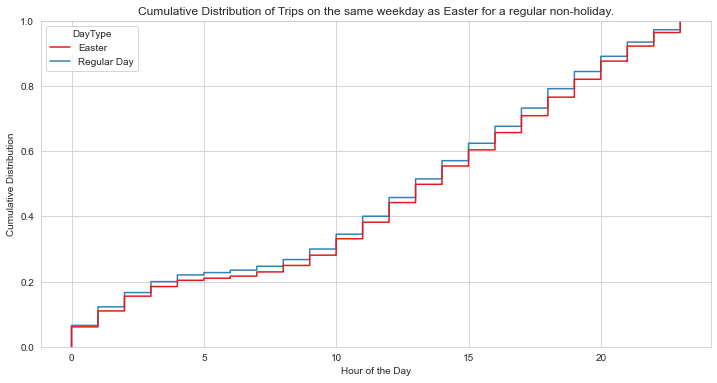

<Figure size 432x288 with 0 Axes>

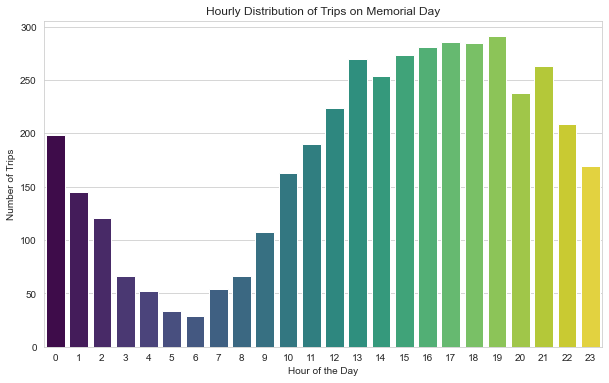

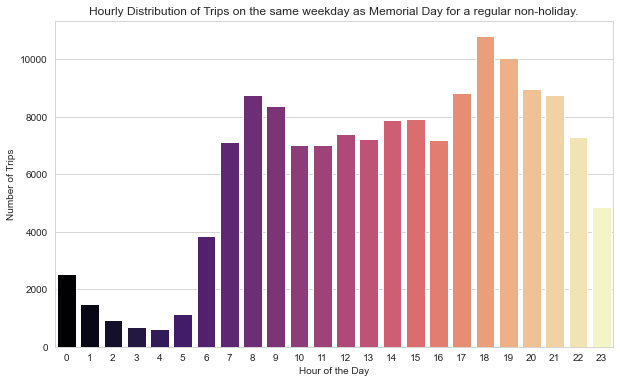

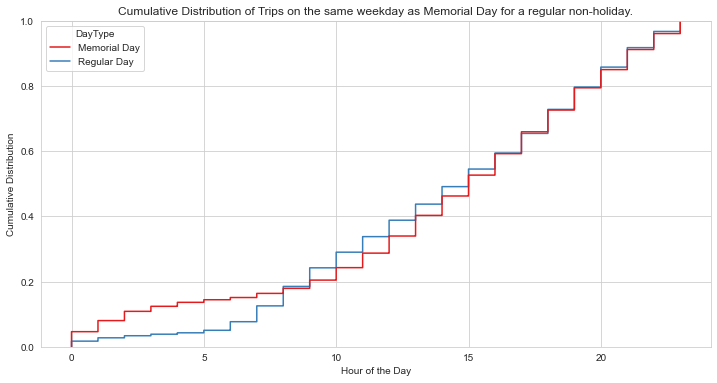

<Figure size 432x288 with 0 Axes>

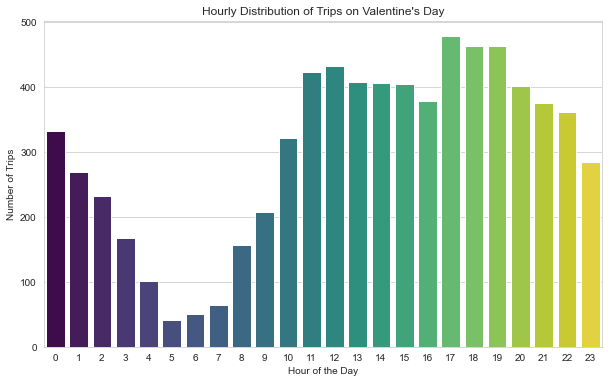

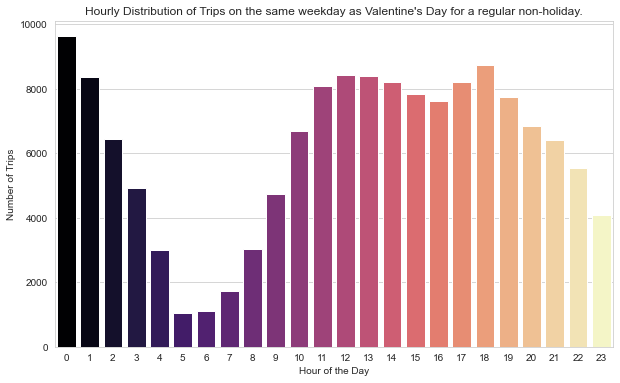

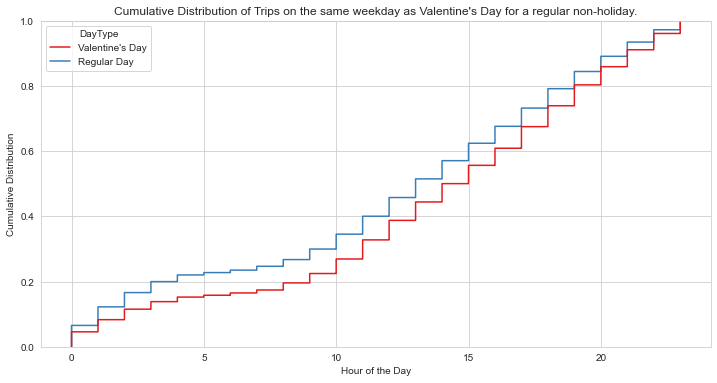

<Figure size 432x288 with 0 Axes>

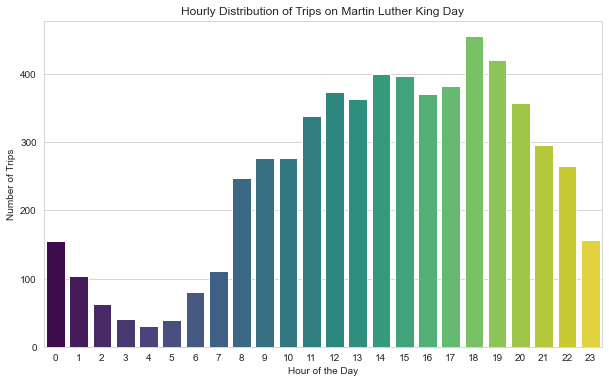

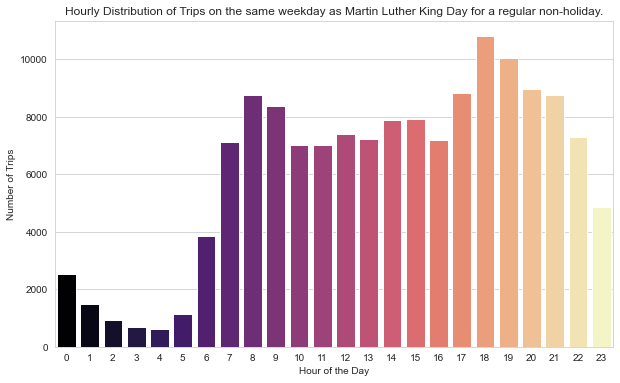

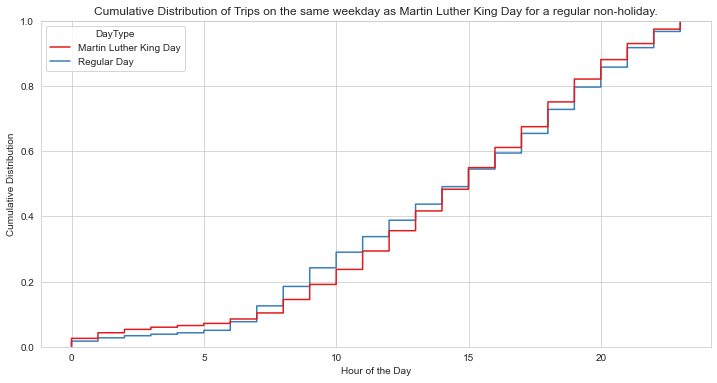

<Figure size 432x288 with 0 Axes>

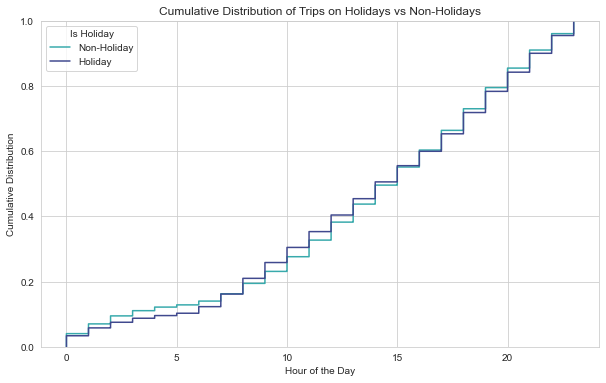

In [179]:
output_folder = "./Plots/Plots[3]/Plots[3.4]"

# Define major holidays in 2016
holidays_2016 = {
    'St. Patrick\'s Day': '2016-03-17',
    'Easter': '2016-03-27',
    'Memorial Day': '2016-05-30',
    'Valentine\'s Day': '2016-02-14',
    'Martin Luther King Day': '2016-01-18'
}

# Convert holiday dates to datetime objects
holiday_dates = pd.to_datetime(list(holidays_2016.values()))

df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])
df['dropoff_datetime'] = pd.to_datetime(df['dropoff_datetime'])

# Create a new column indicating whether the trip occurred on a major holiday
df['is_holiday'] = df['pickup_datetime'].dt.normalize().isin(holiday_dates)

# Compare trip counts on holidays vs non-holidays
holiday_vs_nonholiday_counts = df['is_holiday'].value_counts()
plt.figure(figsize=(8, 5))
sns.barplot(x=['Non-Holiday', 'Holiday'], y=holiday_vs_nonholiday_counts, hue=['Non-Holiday', 'Holiday'], dodge=False, estimator="sum", palette='viridis')
plt.xlabel('Day Type')
plt.ylabel('Number of Trips')
plt.title('Number of Trips on Holidays vs Non-Holidays')
# Save the figure
plt.savefig(os.path.join(output_folder, "trips_holidays_vs_nonholidays.png"))
plt.show()

# Analyze differences during holidays
for holiday, date in holidays_2016.items():
    holiday_data = df[df['pickup_datetime'].dt.date == pd.to_datetime(date).date()]
    
    # Compare with the same day of the week
    day_of_week = pd.to_datetime(date).weekday()
    weekday_data = df[(df['day_of_week'] == day_of_week) & (~df['is_holiday'])]

    plt.figure(figsize=(10, 6))
    sns.countplot(data=holiday_data, x='pickup_hour', hue='pickup_hour', legend=False, palette='viridis')
    plt.xlabel('Hour of the Day')
    plt.ylabel('Number of Trips')
    plt.title(f'Hourly Distribution of Trips on {holiday}')
    plt.savefig(os.path.join(output_folder, f"{holiday.replace(' ', '_').lower()}_hourly_distribution.png"))
    plt.show()

    # Compare to same day of week on non-holidays
    plt.figure(figsize=(10, 6))
    sns.countplot(data=weekday_data, x='pickup_hour', hue='pickup_hour', legend=False, palette='magma')
    plt.xlabel('Hour of the Day')
    plt.ylabel('Number of Trips')
    plt.title(f'Hourly Distribution of Trips on the same weekday as {holiday} for a regular non-holiday.')
    plt.savefig(os.path.join(output_folder, f"regular_{holiday.split()[0].lower()}_hourly_distribution.png"))
    plt.show()

    # Step 6: Cumulative distribution function (CDF)
    combined_data = pd.concat([holiday_data.assign(DayType=holiday), weekday_data.assign(DayType='Regular Day')])

    plt.figure(figsize=(12, 6))
    sns.ecdfplot(data=combined_data, x='pickup_hour', hue='DayType', palette='Set1')
    plt.xlabel('Hour of the Day')
    plt.ylabel('Cumulative Distribution')
    plt.title(f'Cumulative Distribution of Trips on the same weekday as {holiday} for a regular non-holiday.')
    plt.savefig(os.path.join(output_folder, f"cdf_{holiday.replace(' ', '_').lower()}_vs_regular.png"))
    plt.show()

    plt.clf()

# Holiday vs. Non-Holiday Cumulative Distribution
plt.figure(figsize=(10, 6))
sns.ecdfplot(data=df, x='pickup_hour', hue='is_holiday', palette='mako')
plt.xlabel('Hour of the Day')
plt.ylabel('Cumulative Distribution')
plt.title('Cumulative Distribution of Trips on Holidays vs Non-Holidays')
plt.legend(title='Is Holiday', labels=['Non-Holiday', 'Holiday'])
plt.savefig(os.path.join(output_folder, "cdf_holidays_vs_nonholidays.png"))
plt.show()

[3.5] How does the average speed of trips change throughout the day? What time of day are trips fastest? Show plots to motivate your answer.

**Steps:**
- Calculate Average Speed per Hour: Group the data by the hour of the day and calculate the mean speed for each hour.
- Plot the Average Speed: Create a line plot to visualize how average speed changes throughout the day.
- Identify the Fastest Time of Day: Highlight the hour(s) where the average speed is the highest.

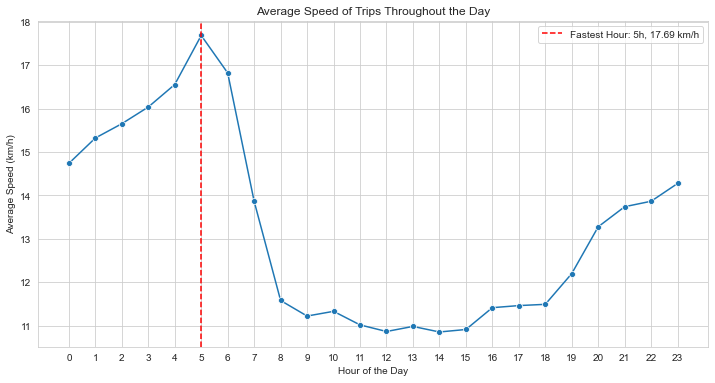

The fastest time of day is around 5:00 with an average speed of 17.69 km/h.


<Figure size 432x288 with 0 Axes>

In [180]:
# Calculate the average speed per hour
avg_speed_per_hour = df.groupby('pickup_hour')['speed_kmh'].mean()

# Step 2: Plot the average speed throughout the day
plt.figure(figsize=(12, 6))
sns.lineplot(x=avg_speed_per_hour.index, y=avg_speed_per_hour.values, marker='o')
plt.xlabel('Hour of the Day')
plt.ylabel('Average Speed (km/h)')
plt.title('Average Speed of Trips Throughout the Day')
plt.xticks(range(0, 24))  # Ensuring all hours are shown on the x-axis
plt.grid(True)

# Highlight the hour(s) with the highest average speed
fastest_hour = avg_speed_per_hour.idxmax()
fastest_speed = avg_speed_per_hour.max()
plt.axvline(x=fastest_hour, color='red', linestyle='--', label=f'Fastest Hour: {fastest_hour}h, {fastest_speed:.2f} km/h')
plt.legend()

plt.savefig('./Plots/Plots[3]/Plots[3.5]/average_speed_throughout_day.png')

plt.show()
plt.clf()

print(f"The fastest time of day is around {fastest_hour}:00 with an average speed of {fastest_speed:.2f} km/h.")
